<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_07/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=ad748b15ea48c80981a44e7f0b8424505385643b846bcbc6728f568143f4988c
  Stored in directory: /tmp/pip-ephem-wheel-cache-zz5267pv/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


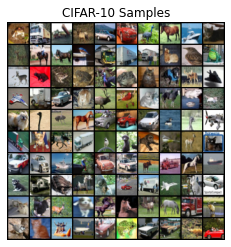

In [4]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [5]:
import torch
from torch import nn
from torch.distributions import Normal, Uniform
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2

#### Generator

In [6]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]

        output = torch.stack(stack, 0)
        output = output.transpose(0, 1)
        output = output.permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)

        return output


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.model = nn.Sequential(DepthToSpace(block_size=2),
                                   nn.Conv2d(in_dim, 
                                             out_dim, 
                                             kernel_size, 
                                             stride=stride, 
                                             padding=padding)) 

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        return self.model(x)

    
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.model = nn.Sequential(nn.BatchNorm2d(in_dim),
                                    nn.ReLU(),
                                    nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                    nn.BatchNorm2d(n_filters),
                                    nn.ReLU(),
                                    Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        residual = self.model(_x)  
        shortcut = self.shortcut(x)
        return residual + shortcut


class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.p_z = Normal(0, 1)
        self.start_stack = nn.Linear(128, 4*4*256)
        self.middle_stack = lambda x: x.reshape((-1, 256, 4, 4)) # reshape output of linear layer
        self.model = nn.Sequential(ResnetBlockUp(in_dim=256, n_filters=n_filters),
                                   ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                   nn.BatchNorm2d(n_filters),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=n_filters, 
                                             out_channels=3, 
                                             kernel_size=(3, 3), 
                                             padding=1),
                                   nn.Tanh())

    def forward(self, n_samples=1_024):
        z = self.p_z.sample([n_samples, 128]).to(device)
        # print(z.shape)
        z = self.start_stack(z)
        # print(z.shape)
        z = self.middle_stack(z)
        # print(z.shape)
        z = self.model(z)
        # print(z.shape)
        return z



#### Discriminator

In [7]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output
       

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.start_stack = SpaceToDepth(block_size=2)
        # self.middle_stack = lambda x: torch.sum(x.chunk(4, dim=1)) / 4.0
        self.middle_stack = lambda x: torch.stack(x.chunk(4, dim=1), dim=1).sum(dim=1) / 4.0
        self.model = nn.Conv2d(in_dim, 
                               out_dim, 
                               kernel_size,
                               stride=stride, 
                               padding=padding)
                            #  padding=padding, 
                            #  bias=bias))

    def forward(self, x):
        # print(f"Downsample: {x.shape}")
        x = self.start_stack(x)
        # print(f"Downsample: {x.shape}")
        # print(x)
        x = self.middle_stack(x)
        # print(f"Downsample: {x.shape}")
        x = self.model(x)
        # print(f"Downsample: {x.shape}")
        return x


class ResnetBlockDown(nn.Module):
    '''
    The ResBlockDown module is similar, 
    except it uses Downsample_Conv2d and omits the BatchNorm.
    '''
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=3):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                   nn.ReLU(),
                                   Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        # print(f"ResnetBlockDown 1: {x.shape}")
        residual = self.model(_x) 
        # print(f"ResnetBlockDown 2: {_x.shape}")
        shortcut = self.shortcut(x)
        # print(f"ResnetBlockDown 3: {_x.shape}")
        return residual + shortcut
        

class Discriminator(nn.Module):
    def __init__(self, n_filters=3):
        super().__init__()
        self.model = nn.Sequential(ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockDown(in_dim=n_filters, n_filters=256),
                                #    nn.ReLU())

                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=256,  # maxpooling ? 
                                             out_channels=3, 
                                             kernel_size=(3, 3), 
                                             padding=1))
                                   # nn.Tanh() ?

        # self.middle_stack = lambda x: x.reshape((-1, 256*4*4)) # reshape output of linear layer
        # self.finish_stack = nn.Linear(256*4*4, 1) # ReLu ?

        self.middle_stack = lambda x: x.reshape((-1, 3*4*4)) # reshape output of linear layer
        self.finish_stack = nn.Linear(3*4*4, 1) # ReLu ?

    def forward(self, x):
        # print(x.shape)
        x = self.model(x)
        # print(x.shape)
        x = self.middle_stack(x)
        # print(x.shape)
        x = self.finish_stack(x)
        return x

In [11]:
# debug 0

model = Generator().to(device)
out = model(n_samples=10)
print(out.shape)

model_2 = Discriminator().to(device)
out_2 = model_2(out)
print(out_2.shape)

out_2.device

torch.Size([10, 3, 32, 32])
torch.Size([10, 1])


device(type='cuda', index=0)

In [23]:
def interpolate(real, fake):
    eps = Uniform(0, 1).sample().to(device)
    return eps*real + (1 - eps)*fake


def convert(samples):
    samples = cv2.normalize(samples, None, 
                            alpha = 0, beta = 255, 
                            norm_type = cv2.NORM_MINMAX, 
                            dtype = cv2.CV_32F)
    return samples.astype(np.uint8) / 255.
    

class SN_WGAN_GP:

    def __init__(self, gen_n_filters=128, dis_n_filters=3, lmbd=10):
        '''
        - λ=10
        - ResBlocks: n_filters=128
        '''
        self.lmbd = lmbd
        self.gen = Generator(n_filters=gen_n_filters).to(device)
        self.dis = Discriminator(n_filters=dis_n_filters).to(device)


    def sample(self, n_samples=1_000):
        return self.gen(n_samples=n_samples)

    def compute_penalty(self, inter_score, inter):
        # print()
        # print(f"inter.shape: {inter.shape}")
        '''compute grad'''
        inter_score_grad = torch.autograd.grad(outputs=inter_score, 
                                               inputs=inter, 
                                               grad_outputs=torch.ones_like(inter_score))[0]    
        # print(f"inter_score_grad.shape: {inter_score_grad.shape}")

        '''compute norm'''
        inter_score_grad_norm = torch.zeros((10, 1))
        for i, matrix in enumerate(inter_score_grad):
            inter_score_grad_norm[i][0] = matrix.norm()
        # print(f"inter_score_grad_norm.shape: {inter_score_grad_norm.shape}")

        '''penalty'''
        penalty = (inter_score_grad_norm - 1)**2
        # print(f"penalty.shape: {penalty.shape}")

        return penalty


    def dis_loss(self, real, fake):
        inter = interpolate(real, fake)

        real_score = self.dis(real)
        fake_score = self.dis(fake)
        inter_score = self.dis(inter)

        # print(f"real_score.shape: {real_score.shape}")
        # print(f"fake_score.shape: {fake_score.shape}")
        # print(f"inter_score.shape: {inter_score.shape}")

        penalty = self.compute_penalty(inter_score, inter)

        dis_loss = -real_score.mean() + \
                    fake_score.mean() + \
                    penalty.mean() * self.lmbd

        return dis_loss


    def gen_loss(self, fake):
        fake_score = self.dis(fake)
        gen_loss = -fake_score.mean()
        return gen_loss


    def train(self, 
              train_data, 
              grad_steps=25_000, 
              batch_size=256, 
              alpha=2e-4, 
              beta_1=0, 
              beta_2=0.9,
              n_critic=5):
        '''
        We'll implement WGAN-GP, which uses a gradient penalty to regularize the discriminator:
        - Adam optimizer: α=2e−4, β1=0, β2=0.9
        - n_critic=5
        - batch size=256
        - gradient steps >= 25_000
        - lr linearly annealed to 0 over training
        '''
        num_epochs = int(grad_steps / batch_size)
        gen_grad_steps = int(grad_steps / n_critic)
        dis_grad_steps = int((n_critic - 1) * grad_steps / n_critic)

        gen_opt = Adam(self.gen.parameters(), lr=alpha, betas=(beta_1, beta_2))
        dis_opt = Adam(self.dis.parameters(), lr=alpha, betas=(beta_1, beta_2))
        
        gen_scheduler = LinearLR(gen_opt, start_factor=1, end_factor=0, total_iters=gen_grad_steps)
        dis_scheduler = LinearLR(dis_opt, start_factor=1, end_factor=0, total_iters=dis_grad_steps)

        dataloader = DataLoader(train_data, 
                                batch_size=batch_size,
                                shuffle=True)
        
        dis_losses = []
        gen_losses = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")

            for i, batch in enumerate(tqdm(dataloader, desc="batches")):
                
                if i % n_critic != 0 or i == 0: # the very first iteration is for critic
                    '''discriminator update'''
                    real = batch.to(device)
                    fake = self.gen(n_samples=batch_size)

                    dis_loss = self.dis_loss(real, fake)
                    dis_opt.zero_grad()
                    dis_loss.backward()
                    dis_opt.step()
                    dis_scheduler.step() # here ?

                    dis_losses.append(dis_loss.item())

                else:
                    '''generator update'''
                    fake = self.gen(n_samples=batch_size)

                    gen_loss = self.gen_loss(fake)
                    gen_opt.zero_grad()
                    gen_loss.backward()
                    gen_opt.step()
                    gen_scheduler.step() # here ?

                    gen_losses.append(gen_loss.item())

            if len(dis_losses) > 0 and len(gen_losses) > 0:
                print(f"last dis_loss: {dis_losses[-1]} | last gen_loss: {gen_losses[-1]}")

        return dis_losses, gen_losses

In [18]:
### debug 1

MODEL = SN_WGAN_GP()
imgs = MODEL.sample(n_samples=100)
imgs = imgs.detach()
print(imgs.device)

dis_losses, gen_losses = MODEL.train(imgs, batch_size=10, grad_steps=20)
# dis_losses, gen_losses = MODEL.train(imgs, batch_size=10, grad_steps=100)

cuda:0
Epoch: 0


batches: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]


last dis_loss: 9.850144386291504 | last gen_loss: 0.010870945639908314
Epoch: 1


batches: 100%|██████████| 10/10 [00:00<00:00, 12.70it/s]

last dis_loss: 9.74440860748291 | last gen_loss: 0.10498826950788498


In [19]:
### debug 2

train_data = load_q1_data()
train_data = train_data.data.transpose((0, 3, 1, 2)) / 255.0

print(train_data.dtype)
_train_data = torch.from_numpy(train_data)
print(_train_data.dtype)
_train_data = _train_data.float()
print(_train_data.dtype)

Files already downloaded and verified
float64
torch.float64
torch.float32


In [24]:
MODEL = SN_WGAN_GP()

dis_losses, _ = MODEL.train(_train_data[:100], grad_steps=100, batch_size=10)
samples = MODEL.sample(n_samples=1_000).detach().cpu().numpy().transpose((0, 2, 3, 1))
samples = convert(samples)

Epoch: 0


batches: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


last dis_loss: 9.19277286529541 | last gen_loss: 0.7376839518547058
Epoch: 1


batches: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


last dis_loss: 8.672507286071777 | last gen_loss: 1.5564780235290527
Epoch: 2


batches: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


last dis_loss: 8.278182983398438 | last gen_loss: 2.2518441677093506
Epoch: 3


batches: 100%|██████████| 10/10 [00:00<00:00, 12.32it/s]


last dis_loss: 8.368163108825684 | last gen_loss: 3.0869433879852295
Epoch: 4


batches: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s]


last dis_loss: 8.607988357543945 | last gen_loss: 3.15795636177063
Epoch: 5


batches: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s]


last dis_loss: 8.905815124511719 | last gen_loss: 2.9469010829925537
Epoch: 6


batches: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s]


last dis_loss: 9.069808006286621 | last gen_loss: 2.5704171657562256
Epoch: 7


batches: 100%|██████████| 10/10 [00:00<00:00, 12.55it/s]


last dis_loss: 9.351530075073242 | last gen_loss: 2.2675819396972656
Epoch: 8


batches: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]


last dis_loss: 9.333444595336914 | last gen_loss: 2.059159755706787
Epoch: 9


batches: 100%|██████████| 10/10 [00:00<00:00, 12.55it/s]


last dis_loss: 9.4073486328125 | last gen_loss: 1.9930254220962524


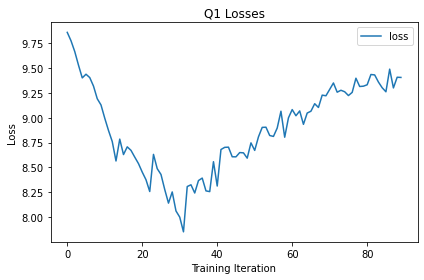

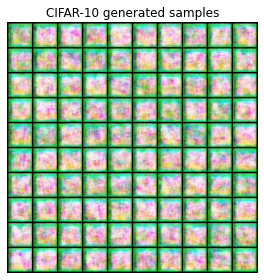

In [26]:
plot_gan_training(dis_losses, 'Q1 Losses', 'results/q1_losses.png')

show_samples(samples[:100] * 255.0, 
             fname='results/q1_samples.png', 
             title=f'CIFAR-10 generated samples')

In [27]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    '''
    Hyperparameters
    '''    
    gen_n_filters=128
    dis_n_filters=3
    lmbd=10
    # grad_steps=25_000
    grad_steps=100
    # batch_size=256
    batch_size=10
    alpha=2e-4
    beta_1=0
    beta_2=0.9
    n_critic=5
    n_samples=1_000

    train_data = torch.from_numpy(train_data).float()

    model = SN_WGAN_GP(gen_n_filters=gen_n_filters,
                       dis_n_filters=dis_n_filters,
                       lmbd=lmbd)

    # dis_losses, _ = model.train(train_data,
    dis_losses, _ = model.train(train_data[:100],
                                grad_steps=grad_steps,
                                batch_size=batch_size,
                                alpha=alpha,
                                beta_1=beta_1,
                                beta_2=beta_2,
                                n_critic=n_critic)

    # samples = model.sample(n_samples=n_samples).detach().numpy().transpose((0, 2, 3, 1))
    samples = model.sample(n_samples=n_samples).detach().cpu().numpy().transpose((0, 2, 3, 1))
    samples = convert(samples)

    return dis_losses, samples

## Results

Files already downloaded and verified
Epoch: 0


batches: 100%|██████████| 10/10 [00:00<00:00, 10.65it/s]


last dis_loss: 8.918033599853516 | last gen_loss: 0.147027850151062
Epoch: 1


batches: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


last dis_loss: 7.435507297515869 | last gen_loss: 0.01938537321984768
Epoch: 2


batches: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


last dis_loss: 6.627651691436768 | last gen_loss: -0.4508867859840393
Epoch: 3


batches: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s]


last dis_loss: 6.92374324798584 | last gen_loss: -2.0423943996429443
Epoch: 4


batches: 100%|██████████| 10/10 [00:00<00:00, 12.59it/s]


last dis_loss: 7.7226948738098145 | last gen_loss: -1.7659786939620972
Epoch: 5


batches: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


last dis_loss: 8.010878562927246 | last gen_loss: -2.2121379375457764
Epoch: 6


batches: 100%|██████████| 10/10 [00:00<00:00, 12.89it/s]


last dis_loss: 8.904014587402344 | last gen_loss: -1.7126072645187378
Epoch: 7


batches: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s]


last dis_loss: 8.872095108032227 | last gen_loss: -1.4688395261764526
Epoch: 8


batches: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]


last dis_loss: 9.204206466674805 | last gen_loss: -1.3453983068466187
Epoch: 9


batches: 100%|██████████| 10/10 [00:00<00:00, 12.65it/s]


last dis_loss: 9.287015914916992 | last gen_loss: -1.3924119472503662
..........Inception score: 1.3744766


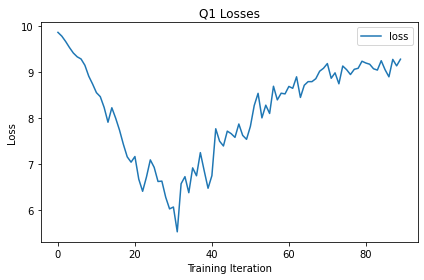

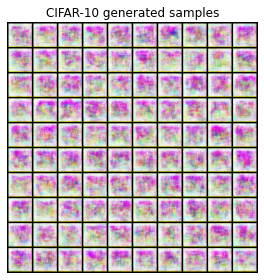

In [28]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


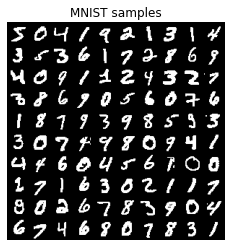

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """

## Results

In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

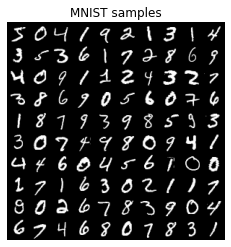

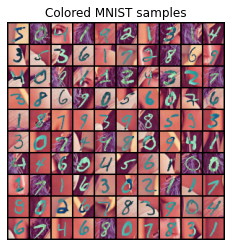

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

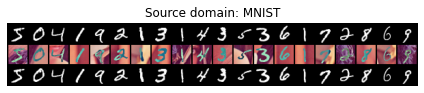

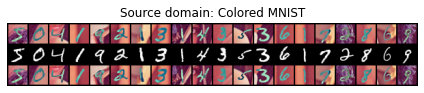

In [ ]:
b5_save_results(b5)